# A2: NeuralNetwork Class

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Requirements" data-toc-modified-id="Requirements-1">Requirements</a></span></li><li><span><a href="#Code-for-NeuralNetwork-Class" data-toc-modified-id="Code-for-NeuralNetwork-Class-2">Code for <code>NeuralNetwork</code> Class</a></span></li><li><span><a href="#Example-Results" data-toc-modified-id="Example-Results-3">Example Results</a></span></li><li><span><a href="#Application-to-Boston-Housing-Data" data-toc-modified-id="Application-to-Boston-Housing-Data-4">Application to Boston Housing Data</a></span></li></ul></div>

## Requirements

In this assignment, you will complete the implementation of the `NeuralNetwork` class, starting with the code included in the next code cell.  Your implementation must meet the requirements described in the doc-strings.

Download [optimizers.tar](https://www.cs.colostate.edu/~anderson/cs545/notebooks/optimizers.tar) and extract `optimizers.py` for use in this assignment.

Then apply your `NeuralNetwork` class to the problem of predicting the value of houses in Boston as described below.

## Code for `NeuralNetwork` Class

In [1]:
%%writefile neuralnetwork.py

import numpy as np
import optimizers as opt


class NeuralNetwork():
    """
    A class that represents a neural network for nonlinear regression

    Attributes
    ----------
    n_inputs : int
        The number of values in each sample
    n_hidden_units_by_layers: list of ints, or empty
        The number of units in each hidden layer.
        Its length specifies the number of hidden layers.
    n_outputs: int
        The number of units in output layer
    all_weights : one-dimensional numpy array
        Contains all weights of the network as a vector
    Ws : list of two-dimensional numpy arrays
        Contains matrices of weights in each layer,
        as views into all_weights
    all_gradients : one-dimensional numpy array
        Contains all gradients of mean square error with
        respect to each weight in the network as a vector
    Grads : list of two-dimensional numpy arrays
        Contains matrices of gradients weights in each layer,
        as views into all_gradients
    total_epochs : int
        Total number of epochs trained so far
    error_trace : list
        Mean square error (standardized) after each epoch
    X_means : one-dimensional numpy array
        Means of the components, or features, across samples
    X_stds : one-dimensional numpy array
        Standard deviations of the components, or features, across samples
    T_means : one-dimensional numpy array
        Means of the components of the targets, across samples
    T_stds : one-dimensional numpy array
        Standard deviations of the components of the targets, across samples
        
    Methods
    -------
    make_weights_and_views(shapes)
        Creates all initial weights and views for each layer

    train(X, T, n_epochs, method='sgd', learning_rate=None, verbose=True)
        Trains the network using samples by rows in X and T

    use(X)
        Applies network to inputs X and returns network's output
    """

    def __init__(self, n_inputs, n_hidden_units_by_layers, n_outputs):

        """Creates a neural network with the given structure

        Parameters
        ----------
        n_inputs : int
            The number of values in each sample
        n_hidden_units_by_layers : list of ints, or empty
            The number of units in each hidden layer.
            Its length specifies the number of hidden layers.
        n_outputs : int
            The number of units in output layer

        Returns
        -------
        NeuralNetwork object
        """

        # Assign attribute values. Set self.X_means to None to indicate
        # that standardization parameters have not been calculated.
        # ....
        self.n_inputs = n_inputs
        self.n_hidden_units_by_layers = n_hidden_units_by_layers
        self.n_outputs = n_outputs
        self.X_means = None
        self.X_stds = None
        self.T_means = None
        self.T_stds = None
        self.total_epochs = 0
        self.error_trace = []
        # Build list of shapes for weight matrices in each layer
        # ...
        weight_list_shapes = []
        n = self.n_hidden_units_by_layers 
        if(len(n)):
            weight_list_shapes.append((self.n_inputs + 1, self.n_hidden_units_by_layers[0]))
            for i in range(len(self.n_hidden_units_by_layers)): 
                #Iterate to each and every hidden layer
                weight_list_shapes.append((self.n_hidden_units_by_layers[i] + 1, self.n_hidden_units_by_layers[i+1] 
                if i + 1 < len(self.n_hidden_units_by_layers) 
                else self.n_outputs))
        else:
            # Weighted matrix between input layer and output layer
            weight_list_shapes.append((self.n_inputs + 1, self.n_outputs))
        # Call make_weights_and_views to create all_weights and Ws
        self.all_weights, self.Ws = self._make_weights_and_views(weight_list_shapes)
        # Call make_weights_and_views to create all_gradients and Grads
        self.all_gradients, self.Grads = self._make_weights_and_views(weight_list_shapes)

    def _make_weights_and_views(self, shapes):
        """Creates vector of all weights and views for each layer

        Parameters
        ----------
        shapes : list of pairs of ints
            Each pair is number of rows and columns of weights in each layer

        Returns
        -------
        Vector of all weights, and list of views into this vector for each layer
        """

        # Create one-dimensional numpy array of all weights with random initial values
        #  ...
        
        weight = 0
        for i in shapes:
            weight = weight + i[0] * i[1]
        all_weights = np.random.uniform(-1, 1, weight)/self.n_inputs * self.n_outputs
        
        # Build list of views by reshaping corresponding elements
        # from vector of all weights into correct shape for each layer.        
        # ...
        Ws = []
        ind = 0
        for j in shapes:
            ind_len = j[0] * j[1]
            Ws.append(all_weights[ind:ind+ind_len].reshape(j[0], j[1]))
            ind = ind + ind_len
        return all_weights, Ws
    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, ' + \
            f'{self.n_hidden_units_by_layers}, {self.n_outputs})'

    def __str__(self):
        s = self.__repr__()
        if self.total_epochs > 0:
            s += f'\n Trained for {self.total_epochs} epochs.'
            s += f'\n Final standardized training error {self.error_trace[-1]:.4g}.'
        return s
 
    def train(self, X, T, n_epochs, method='sgd', learning_rate=None, verbose=True):
        """Updates the weights 

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  x  number of input components
        T : two-dimensional numpy array
            number of samples  x  number of output components
        n_epochs : int
            Number of passes to take through all samples
        method : str
            'sgd', 'adam', or 'scg'
        learning_rate : float
            Controls the step size of each update, only for sgd and adam
        verbose: boolean
            If True, progress is shown with print statements
        """

        # Calculate and assign standardization parameters
        # ...
        self.X_means = X.mean(axis=0)
        self.X_stds = X.std(axis=0)
        self.T_means = T.mean(axis=0)
        self.T_stds = T.std(axis=0)
        # Standardize X and T
        # ...
        Xstd = (X - self.X_means)/ self.X_stds
        Tstd = (T - self.T_means)/ self.T_stds
        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = opt.Optimizers(self.all_weights)

        error_convert_f = lambda err: (np.sqrt(err) * self.T_stds)[0]
        
        # Call the requested optimizer method to train the weights.

        if method == 'sgd':
            error_trace=optimizer.sgd(self.error_f, self.gradient_f, [Xstd,Tstd], n_epochs, 0.01, error_convert_f)
            
        elif method == 'adam':
            error_trace=optimizer.adam(self.error_f, self.gradient_f, [Xstd,Tstd], n_epochs, learning_rate, error_convert_f)

        elif method == 'scg':
            error_trace=optimizer.scg(self.error_f, self.gradient_f, [Xstd,Tstd], n_epochs, error_convert_f)
        else:
            raise Exception("method must be 'sgd', 'adam', or 'scg'")

        self.total_epochs += len(error_trace)
        self.error_trace += error_trace

        # Return neural network object to allow applying other methods
        # after training, such as: Y = nnet.train(X, T, 100, 0.01).use(X)

        return self
    

    def _forward(self, X):
        """Calculate outputs of each layer given inputs in X
        
        Parameters
        ----------
        X : input samples, standardized

        Returns
        -------
        Outputs of all layers as list
        """
        self.Ys = [X]
        # Append output of each layer to list in self.Ys, then return it.
        # ...
        n = len(self.Ws)
        for k in range(0,n):
            # From input to hidden layer
            self.Ys.append(np.tanh(self.Ys[k] @ self.Ws[k][1:, :] + self.Ws[k][0:1, :]))
        # From output to hidden layer
        self.Ys.append(self.Ys[k] @ self.Ws[-1][1:, :] + self.Ws[-1][0:1, :])
        return self.Ys # Output of all layers list
    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        """Calculate output of net and its mean squared error 

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  x  number of input components
        T : two-dimensional numpy array
            number of samples  x  number of output components

        Returns
        -------
        Mean square error as scalar float that is the mean
        square error over all samples
        """
        # Call _forward, calculate mean square error and return it.
        # ...
        Y_F = self._forward(X)[-1]
        return np.sqrt(np.mean((T - Y_F)**2))

    def gradient_f(self, X, T):
        """Returns gradient wrt all weights. Assumes _forward already called.

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  x  number of input components
        T : two-dimensional numpy array
            number of samples  x  number of output components

        Returns
        -------
        Vector of gradients of mean square error wrt all weights
        """

        # Assumes forward_pass just called with layer outputs saved in self.Ys.
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        n_layers = len(self.n_hidden_units_by_layers) + 1

        # D is delta matrix to be back propagated
        D = -(T - self.Ys[-1]) / (n_samples * n_outputs)

        # Step backwards through the layers to back-propagate the error (D)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.Grads[layeri][1:, :] = self.Ys[layeri].T @ D
            # gradient of just the bias weights
            self.Grads[layeri][0:1, :] = np.sum(D, axis=0)
            # Back-propagate this layer's delta to previous layer
            if layeri > 0:
                D = D @ self.Ws[layeri][1: , :].T
                D = D * (1 - self.Ys[layeri] ** 2)

        return self.all_gradients

    def use(self, X):
        """Return the output of the network for input samples as rows in X

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  x  number of input components, unstandardized

        Returns
        -------
        Output of neural network, unstandardized, as numpy array
        of shape  number of samples  x  number of outputs
        """

        # Standardize X
        # ...
        X_means = X.mean(axis=0)
        X_stds = X.std(axis=0)
        XS = (X - self.X_means) / self.X_stds
        YS = self._forward(XS)
        # Unstandardize output Y before returning it
        Y = YS[-1] * self.T_stds + self.T_means
        return Y

    def get_error_trace(self):
        """Returns list of standardized mean square error for each epoch"""
        return self.error_trace

Overwriting neuralnetwork.py


## Example Results

Here we test the `NeuralNetwork` class with some simple data.  



method is sgd and rho is 0.01

sgd: Epoch 1 ObjectiveF=1.00005
sgd: Epoch 2 ObjectiveF=1.00005
sgd: Epoch 3 ObjectiveF=1.00005
sgd: Epoch 4 ObjectiveF=1.00005
sgd: Epoch 5 ObjectiveF=1.00004
sgd: Epoch 6 ObjectiveF=1.00004
sgd: Epoch 7 ObjectiveF=1.00004
sgd: Epoch 8 ObjectiveF=1.00003
sgd: Epoch 9 ObjectiveF=1.00003
sgd: Epoch 10 ObjectiveF=1.00002

method is adam and rho is 0.005

Adam: Epoch 1 ObjectiveF=1.00005
Adam: Epoch 2 ObjectiveF=1.00001
Adam: Epoch 3 ObjectiveF=1.00000
Adam: Epoch 4 ObjectiveF=1.00001
Adam: Epoch 5 ObjectiveF=1.00001
Adam: Epoch 6 ObjectiveF=1.00002
Adam: Epoch 7 ObjectiveF=1.00001
Adam: Epoch 8 ObjectiveF=0.99999
Adam: Epoch 9 ObjectiveF=0.99997
Adam: Epoch 10 ObjectiveF=0.99995

method is scg and rho is None

SCG: Epoch 1 ObjectiveF=0.56991
SCG: Epoch 2 ObjectiveF=0.56991
SCG: Epoch 3 ObjectiveF=0.56991
SCG: Epoch 4 ObjectiveF=0.56991
SCG: Epoch 5 ObjectiveF=0.56991
SCG: Epoch 6 ObjectiveF=0.56989
SCG: Epoch 7 ObjectiveF=0.56962
SCG: Epoch 8 ObjectiveF=0.

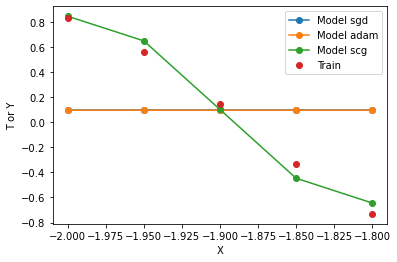

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import neuralnetwork as nn

X = np.arange(-2, 2, 0.05).reshape(-1, 1)
T = np.sin(X) * np.sin(X * 10)

# Just use first 5 samples
X = X[:5, :]
T = T[:5, :]

errors = []
# n_epochs = 1000
n_epochs = 10

method_rhos = [('sgd', 0.01),
               ('adam', 0.005),
               ('scg', None)]

for method, rho in method_rhos:
    
    print('\n=========================================')
    print(f'method is {method} and rho is {rho}')
    print('=========================================\n')

    nnet = nn.NeuralNetwork(X.shape[1], [2, 2], 1)
    
    # Set all weights here to allow comparison of your calculations
    # Must use [:] to overwrite values in all_weights.
    # Without [:], new array is assigned to self.all_weights, so self.Ws no longer refer to same memory
    nnet.all_weights[:] = np.arange(len(nnet.all_weights)) * 0.001
    
    nnet.train(X, T, n_epochs, method=method, learning_rate=rho)
    Y = nnet.use(X)
    plt.plot(X, Y, 'o-', label='Model ' + method)
    errors.append(nnet.get_error_trace())

plt.plot(X, T, 'o', label='Train')
plt.xlabel('X')
plt.ylabel('T or Y')
plt.legend();

sgd: Epoch 5000 ObjectiveF=0.98899
sgd: Epoch 10000 ObjectiveF=0.91824
sgd: Epoch 15000 ObjectiveF=0.71938
sgd: Epoch 20000 ObjectiveF=0.71689
sgd: Epoch 25000 ObjectiveF=0.71370
sgd: Epoch 30000 ObjectiveF=0.69130
sgd: Epoch 35000 ObjectiveF=0.66446
sgd: Epoch 40000 ObjectiveF=0.54282
sgd: Epoch 45000 ObjectiveF=0.40566
sgd: Epoch 50000 ObjectiveF=0.06898
Adam: Epoch 5000 ObjectiveF=0.48005
Adam: Epoch 10000 ObjectiveF=0.36374
Adam: Epoch 15000 ObjectiveF=0.06625
Adam: Epoch 20000 ObjectiveF=0.04100
Adam: Epoch 25000 ObjectiveF=0.03920
Adam: Epoch 30000 ObjectiveF=0.01618
Adam: Epoch 35000 ObjectiveF=0.01426
Adam: Epoch 40000 ObjectiveF=0.01457
Adam: Epoch 45000 ObjectiveF=0.01098
Adam: Epoch 50000 ObjectiveF=0.01054
SCG: Epoch 5000 ObjectiveF=0.03985
SCG: Epoch 10000 ObjectiveF=0.03246
SCG: Epoch 15000 ObjectiveF=0.02961
SCG: Epoch 20000 ObjectiveF=0.02810
SCG: Epoch 25000 ObjectiveF=0.02685
SCG: Epoch 30000 ObjectiveF=0.02576
SCG: Epoch 35000 ObjectiveF=0.02486
SCG: Epoch 40000 Obje

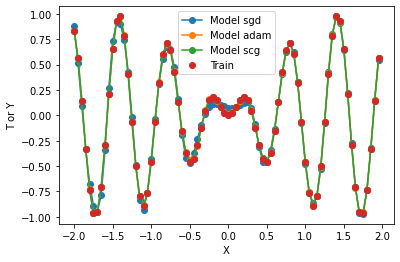

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import neuralnetwork as nn

X = np.arange(-2, 2, 0.05).reshape(-1, 1)
T = np.sin(X) * np.sin(X * 10)

errors = []
n_epochs = 1000
method_rhos = [('sgd', 0.01),
               ('adam', 0.005),
               ('scg', None)]

for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(X.shape[1], [10, 10], 1)
    nnet.train(X, T, 50000, method=method, learning_rate=rho)
    Y = nnet.use(X)
    plt.plot(X, Y, 'o-', label='Model ' + method)
    errors.append(nnet.get_error_trace())

plt.plot(X, T, 'o', label='Train')
plt.xlabel('X')
plt.ylabel('T or Y')
plt.legend();

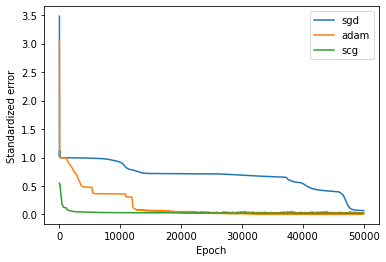

In [4]:
plt.figure(2)
plt.clf()
for error_trace in errors:
    plt.plot(error_trace)
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend([mr[0] for mr in method_rhos]);

Your results will not be the same, but your code should complete and make plots somewhat similar to these.

## Application to Boston Housing Data

Download data from [Boston House Data at Kaggle](https://www.kaggle.com/fedesoriano/the-boston-houseprice-data). Read it into python using the `pandas.read_csv` function.  Assign the first 13 columns as inputs to `X` and the final column as target values to `T`.  Make sure `T` is two-dimensional.

Before training your neural networks, partition the data into training and testing partitions, as shown here.

In [5]:
def partition(X, T, train_fraction):
    n_samples = X.shape[0]
    rows = np.arange(n_samples)
    np.random.shuffle(rows)
    
    n_train = round(n_samples * train_fraction)
    
    Xtrain = X[rows[:n_train], :]
    Ttrain = T[rows[:n_train], :]
    Xtest = X[rows[n_train:], :]
    Ttest = T[rows[n_train:], :]
    return Xtrain, Ttrain, Xtest, Ttest
    
def rmse(T, Y):
    return np.sqrt(np.mean((T - Y)**2))

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neuralnetwork as nn

In [7]:
bos_data = pd.read_csv('boston.csv')
bos_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [8]:
bos_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [9]:
bos_data.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


In [10]:
X = bos_data[['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT']].values
T = bos_data['MEDV'].values.reshape(-1,1)

In [11]:
Xtrain, Ttrain, Xtest, Ttest = partition(X, T, 0.8) 
print(f'{Xtrain.shape=} {Ttrain.shape=} {Xtest.shape=} {Ttest.shape=}')

Xtrain.shape=(405, 13) Ttrain.shape=(405, 1) Xtest.shape=(101, 13) Ttest.shape=(101, 1)


sgd: Epoch 1000 ObjectiveF=0.26532
sgd: Epoch 2000 ObjectiveF=0.22083
sgd: Epoch 3000 ObjectiveF=0.19199
sgd: Epoch 4000 ObjectiveF=0.18153
sgd: Epoch 5000 ObjectiveF=0.17339
sgd: Epoch 6000 ObjectiveF=0.16347
sgd: Epoch 7000 ObjectiveF=0.15431
sgd: Epoch 8000 ObjectiveF=0.14755
sgd: Epoch 9000 ObjectiveF=0.14178
sgd: Epoch 10000 ObjectiveF=0.13755

RMSE for training value =  1.2612893620827275 
RMSE for testing value =  2.934694456053545 

Adam: Epoch 1000 ObjectiveF=0.16462
Adam: Epoch 2000 ObjectiveF=0.13225
Adam: Epoch 3000 ObjectiveF=0.10893
Adam: Epoch 4000 ObjectiveF=0.08960
Adam: Epoch 5000 ObjectiveF=0.07679
Adam: Epoch 6000 ObjectiveF=0.06901
Adam: Epoch 7000 ObjectiveF=0.06142
Adam: Epoch 8000 ObjectiveF=0.05635
Adam: Epoch 9000 ObjectiveF=0.05117
Adam: Epoch 10000 ObjectiveF=0.04666

RMSE for training value =  0.42787420918078395 
RMSE for testing value =  4.659165595426961 

SCG: Epoch 1000 ObjectiveF=2.50122
SCG: Epoch 2000 ObjectiveF=1.88970
SCG: Epoch 3000 ObjectiveF=1.

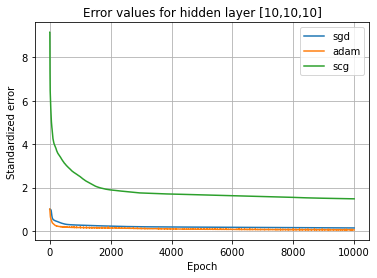

In [12]:
errors = []
n_epochs = 10000
method_rhos = [('sgd', 0.01),
               ('adam', 0.01),
               ('scg', None)]

for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [10, 10, 10], 2)
    nnet.train(Xtrain, Ttrain, n_epochs, method=method, learning_rate=rho, verbose=False)
    Ytrain = nnet.use(Xtrain)
    Ytest = nnet.use(Xtest)
    rmse_train = rmse(Ttrain, Ytrain)
    rmse_test = rmse(Ttest, Ytest)
    print( '\nRMSE for training value = ', rmse_train, '\nRMSE for testing value = ', rmse_test, '\n')
    errors.append(nnet.get_error_trace())
    
plt.figure()
plt.clf()
for error_trace in errors:
    plt.plot(error_trace)
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend([mr[0] for mr in method_rhos]);
plt.grid()
plt.title('Error values for hidden layer [10,10,10]');

sgd: Epoch 1000 ObjectiveF=0.33064
sgd: Epoch 2000 ObjectiveF=0.28011
sgd: Epoch 3000 ObjectiveF=0.25979
sgd: Epoch 4000 ObjectiveF=0.24040
sgd: Epoch 5000 ObjectiveF=0.21749
sgd: Epoch 6000 ObjectiveF=0.20148
sgd: Epoch 7000 ObjectiveF=0.19126
sgd: Epoch 8000 ObjectiveF=0.18413
sgd: Epoch 9000 ObjectiveF=0.17873
sgd: Epoch 10000 ObjectiveF=0.17371

RMSE for training value =  1.5928533726412508 
RMSE for testing value =  3.829394507371211 

Adam: Epoch 1000 ObjectiveF=0.14275
Adam: Epoch 2000 ObjectiveF=0.10995
Adam: Epoch 3000 ObjectiveF=0.09790
Adam: Epoch 4000 ObjectiveF=0.09146
Adam: Epoch 5000 ObjectiveF=0.08494
Adam: Epoch 6000 ObjectiveF=0.07892
Adam: Epoch 7000 ObjectiveF=0.07543
Adam: Epoch 8000 ObjectiveF=0.07404
Adam: Epoch 9000 ObjectiveF=0.07271
Adam: Epoch 10000 ObjectiveF=0.07053

RMSE for training value =  0.646762292050251 
RMSE for testing value =  5.351015172025425 

SCG: Epoch 1000 ObjectiveF=2.41826
SCG: Epoch 2000 ObjectiveF=2.12034
SCG: Epoch 3000 ObjectiveF=2.05

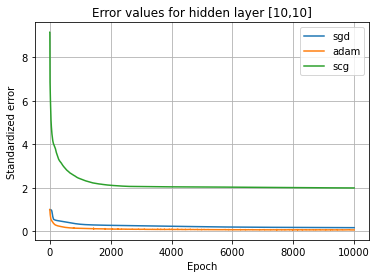

In [13]:
errors = []
n_epochs = 10000
method_rhos = [('sgd', 0.01),
               ('adam', 0.01),
               ('scg', None)]

for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [10, 10], 1)
    nnet.train(Xtrain, Ttrain, n_epochs, method=method, learning_rate=rho, verbose=False)
    Ytrain = nnet.use(Xtrain)
    Ytest = nnet.use(Xtest)
    rmse_train = rmse(Ttrain, Ytrain)
    rmse_test = rmse(Ttest, Ytest)
    print( '\nRMSE for training value = ', rmse_train, '\nRMSE for testing value = ', rmse_test, '\n')
    errors.append(nnet.get_error_trace())
    
plt.figure()
plt.clf()
for error_trace in errors:
    plt.plot(error_trace)
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend([mr[0] for mr in method_rhos]);
plt.grid()
plt.title('Error values for hidden layer [10,10]');

sgd: Epoch 100 ObjectiveF=0.52205
sgd: Epoch 200 ObjectiveF=0.51340
sgd: Epoch 300 ObjectiveF=0.50631
sgd: Epoch 400 ObjectiveF=0.49684
sgd: Epoch 500 ObjectiveF=0.48408
sgd: Epoch 600 ObjectiveF=0.46813
sgd: Epoch 700 ObjectiveF=0.44995
sgd: Epoch 800 ObjectiveF=0.43162
sgd: Epoch 900 ObjectiveF=0.41572
sgd: Epoch 1000 ObjectiveF=0.40296

RMSE for training value =  3.6940206810285825 
RMSE for testing value =  3.4689091625554056 

Adam: Epoch 100 ObjectiveF=0.51910
Adam: Epoch 200 ObjectiveF=0.49706
Adam: Epoch 300 ObjectiveF=0.44733
Adam: Epoch 400 ObjectiveF=0.37289
Adam: Epoch 500 ObjectiveF=0.31175
Adam: Epoch 600 ObjectiveF=0.27168
Adam: Epoch 700 ObjectiveF=0.24578
Adam: Epoch 800 ObjectiveF=0.22615
Adam: Epoch 900 ObjectiveF=0.21151
Adam: Epoch 1000 ObjectiveF=0.20045

RMSE for training value =  1.8372237384400183 
RMSE for testing value =  2.9306779474208104 

SCG: Epoch 100 ObjectiveF=4.62987
SCG: Epoch 200 ObjectiveF=3.78680
SCG: Epoch 300 ObjectiveF=3.28053
SCG: Epoch 400 O

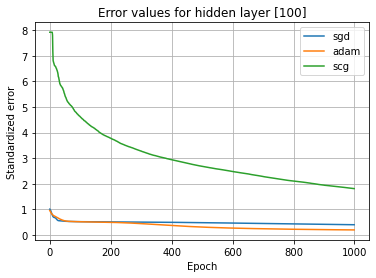

In [14]:
errors = []
n_epochs = 1000
method_rhos = [('sgd', 0.001),
               ('adam', 0.001),
               ('scg', None)]

for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [100], 1)
    nnet.train(Xtrain, Ttrain, n_epochs, method=method, learning_rate=rho, verbose=False)
    Ytrain = nnet.use(Xtrain)
    Ytest = nnet.use(Xtest)
    rmse_train = rmse(Ttrain, Ytrain)
    rmse_test = rmse(Ttest, Ytest)
    print( '\nRMSE for training value = ', rmse_train, '\nRMSE for testing value = ', rmse_test, '\n')
    errors.append(nnet.get_error_trace())
    
plt.figure()
plt.clf()
for error_trace in errors:
    plt.plot(error_trace)
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend([mr[0] for mr in method_rhos]);
plt.grid()
plt.title('Error values for hidden layer [100]');

sgd: Epoch 1000 ObjectiveF=0.24972
sgd: Epoch 2000 ObjectiveF=0.19398
sgd: Epoch 3000 ObjectiveF=0.15869
sgd: Epoch 4000 ObjectiveF=0.13537
sgd: Epoch 5000 ObjectiveF=0.11898
sgd: Epoch 6000 ObjectiveF=0.10589
sgd: Epoch 7000 ObjectiveF=0.09528
sgd: Epoch 8000 ObjectiveF=0.08697
sgd: Epoch 9000 ObjectiveF=0.08020
sgd: Epoch 10000 ObjectiveF=0.07437

RMSE for training value =  0.6819464513928579 
RMSE for testing value =  3.6889566331250974 

Adam: Epoch 1000 ObjectiveF=0.02450
Adam: Epoch 2000 ObjectiveF=0.00991
Adam: Epoch 3000 ObjectiveF=0.00436
Adam: Epoch 4000 ObjectiveF=0.00320
Adam: Epoch 5000 ObjectiveF=0.00450
Adam: Epoch 6000 ObjectiveF=0.00204
Adam: Epoch 7000 ObjectiveF=0.00607
Adam: Epoch 8000 ObjectiveF=0.01430
Adam: Epoch 9000 ObjectiveF=0.00382
Adam: Epoch 10000 ObjectiveF=0.00049

RMSE for training value =  0.004509841737808488 
RMSE for testing value =  3.5752855943200292 

SCG: Epoch 1000 ObjectiveF=1.18073
SCG: Epoch 2000 ObjectiveF=0.49349
SCG: Epoch 3000 ObjectiveF

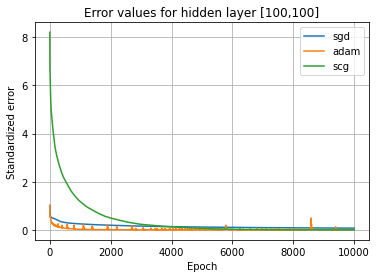

In [15]:
errors = []
n_epochs = 10000
method_rhos = [('sgd', 0.01),
               ('adam', 0.01),
               ('scg', None)]

for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [100, 100], 2)
    nnet.train(Xtrain, Ttrain, n_epochs, method=method, learning_rate=rho, verbose=False)
    Ytrain = nnet.use(Xtrain)
    Ytest = nnet.use(Xtest)
    rmse_train = rmse(Ttrain, Ytrain)
    rmse_test = rmse(Ttest, Ytest)
    print( '\nRMSE for training value = ', rmse_train, '\nRMSE for testing value = ', rmse_test, '\n')
    errors.append(nnet.get_error_trace())
    
plt.figure()
plt.clf()
for error_trace in errors:
    plt.plot(error_trace)
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend([mr[0] for mr in method_rhos]);
plt.grid()
plt.title('Error values for hidden layer [100,100]');

Write and run code using your `NeuralNetwork` class to model the Boston housing data. Experiment with all three optimization methods and a variety of neural network structures (numbers of hidden layer and units), learning rates, and numbers of epochs. Show results for at least three different network structures, learning rates, and numbers of epochs for each method.  Show your results using print statements that include the method, network structure, number of epochs, learning rate, and RMSE on training data and RMSE on testing data.

Try to find good values for the RMSE on testing data.  Discuss your results, including how good you think the RMSE values are by considering the range of house values given in the data. 

## Observations:

i) On implementing the neural network class on the boston housing data using the three optimization methods SGD, Adam and SCG for different neural network structures, I observed that the RMSE values on the training data is comparitively less when using the Adam optimizer and the RMSE values on the testing data is comparatively less when using the SGD.

ii) The best RMSE value for training data = 0.0045 is obtained when using the Adam optimizer where the n_epochs = 10000, rho = 0.01, number of hidden layers = 2 and the number of units in the hidden layers = 100.

iii) The best RMSE value for testing data = 2.9306 is obtained when using the Adam optimizer where the n_epochs = 1000, rho = 0.001, number of hidden layers = 1 and the number of units in the hidden layers = 100.

# Grading

Your notebook will be run and graded automatically. Test this grading process by first downloading [A2grader.tar](http://www.cs.colostate.edu/~anderson/cs545/notebooks/A2grader.tar) and extract `A2grader.py` from it. Run the code in the following cell to demonstrate an example grading session.  The remaining 20 points will be based on your discussion of this assignment.

A different, but similar, grading script will be used to grade your checked-in notebook. It will include additional tests. You should design and perform additional tests on all of your functions to be sure they run correctly before checking in your notebook.  

For the grading script to run correctly, you must first name this notebook as 'Lastname-A2.ipynb' with 'Lastname' being your last name, and then save this notebook.

In [16]:
%run -i A2grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'A2 NeuralNetwork Class.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.
CRITICAL ERROR: NeuralNetwork Function named 'make_weights_and_views' is not defined
  Check the spelling and capitalization of the function name.

Testing

    import neuralnetwork as nn

    n_inputs = 3
    n_hiddens = [10, 20]
    n_outputs = 2
    n_samples = 5

    X = np.arange(n_samples * n_inputs).reshape(n_samples, n_inputs) * 0.1
    
    nnet = nn.NeuralNetwork(n_inputs, n_hiddens, n_outputs)
    nnet.all_weights = 0.1  # set all weights to 0.1
    nnet.X_means = np.mean(X, axis=0)
    nnet.X_stds = np.std(X, axis=0)
    nnet.T_means = np.zeros((n_samples, n_outputs))
    nnet.T_stds = np.ones((n_samples, n_outputs))
    
    Y = nnet.use(X)


--- 40/40 points. Returned correct value.

Testing
    n_inputs = 3
    n_hiddens = 

Adam: Epoch 4000 ObjectiveF=0.00682
Adam: Epoch 4500 ObjectiveF=0.00551
Adam: Epoch 5000 ObjectiveF=0.00548
Net 18 RMSE 0.00371
Adam: Epoch 500 ObjectiveF=0.78303
Adam: Epoch 1000 ObjectiveF=0.18453
Adam: Epoch 1500 ObjectiveF=0.13049
Adam: Epoch 2000 ObjectiveF=0.11694
Adam: Epoch 2500 ObjectiveF=0.11163
Adam: Epoch 3000 ObjectiveF=0.11012
Adam: Epoch 3500 ObjectiveF=0.10987
Adam: Epoch 4000 ObjectiveF=0.11117
Adam: Epoch 4500 ObjectiveF=0.11012
Adam: Epoch 5000 ObjectiveF=0.10988
Net 19 RMSE 0.07704
Adam: Epoch 500 ObjectiveF=0.34251
Adam: Epoch 1000 ObjectiveF=0.07389
Adam: Epoch 1500 ObjectiveF=0.02017
Adam: Epoch 2000 ObjectiveF=0.02379
Adam: Epoch 2500 ObjectiveF=0.00958
Adam: Epoch 3000 ObjectiveF=0.00713
Adam: Epoch 3500 ObjectiveF=0.00734
Adam: Epoch 4000 ObjectiveF=0.00711
Adam: Epoch 4500 ObjectiveF=0.00481
Adam: Epoch 5000 ObjectiveF=0.00580
Net 20 RMSE 0.00372
0.02834282050962968

--- 40/40 points. Returned correct value.

C:\Users\kiran\Downloads Execution Grade is 80 / 8

<Figure size 432x288 with 0 Axes>

# Check-In <font color='red'>Changed Sept 14th, 8:45 AM</font>

Do not include this section in your notebook.

Name your notebook ```Lastname-A2.ipynb```.  So, for me it would be ```Anderson-A2.ipynb```.  

Combine your jupyter notebook file, your `neuralnetwork.py` file, and the `optimizers.py` file in one `tar` or `zip` file. Submit your `tar` or `zip` using the ```Assignment 2``` link on [Canvas](https://colostate.instructure.com/courses/131494).

# Extra Credit

Apply your multilayer neural network code to a regression problem using data that you choose 
from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets.php). Pick a dataset that
is listed as being appropriate for regression.

In [17]:
def partition(X, T, train_fraction):
    n_samples = X.shape[0]
    rows = np.arange(n_samples)
    np.random.shuffle(rows)
    
    n_train = round(n_samples * train_fraction)
    
    Xtrain = X[rows[:n_train], :]
    Ttrain = T[rows[:n_train], :]
    Xtest = X[rows[n_train:], :]
    Ttest = T[rows[n_train:], :]
    return Xtrain, Ttrain, Xtest, Ttest
    
def rmse(T, Y):
    return np.sqrt(np.mean((T - Y)**2))

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neuralnetwork as nn

In [19]:
data = pd.read_csv('Bias_correction_ucl.csv')
data = data.dropna(axis=0)

In [20]:
data.head()

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
0,1.0,2013-06-30,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,...,0.0,0.0,0.0,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2
1,2.0,2013-06-30,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,...,0.0,0.0,0.0,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5
2,3.0,2013-06-30,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,...,0.0,0.0,0.0,37.5776,127.058,33.3068,0.2661,5863.555664,31.1,23.9
3,4.0,2013-06-30,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,...,0.0,0.0,0.0,37.6450,127.022,45.7160,2.5348,5856.964844,31.7,24.3
4,5.0,2013-06-30,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,...,0.0,0.0,0.0,37.5507,127.135,35.0380,0.5055,5859.552246,31.2,22.5


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7588 entries, 0 to 7749
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station           7588 non-null   float64
 1   Date              7588 non-null   object 
 2   Present_Tmax      7588 non-null   float64
 3   Present_Tmin      7588 non-null   float64
 4   LDAPS_RHmin       7588 non-null   float64
 5   LDAPS_RHmax       7588 non-null   float64
 6   LDAPS_Tmax_lapse  7588 non-null   float64
 7   LDAPS_Tmin_lapse  7588 non-null   float64
 8   LDAPS_WS          7588 non-null   float64
 9   LDAPS_LH          7588 non-null   float64
 10  LDAPS_CC1         7588 non-null   float64
 11  LDAPS_CC2         7588 non-null   float64
 12  LDAPS_CC3         7588 non-null   float64
 13  LDAPS_CC4         7588 non-null   float64
 14  LDAPS_PPT1        7588 non-null   float64
 15  LDAPS_PPT2        7588 non-null   float64
 16  LDAPS_PPT3        7588 non-null   float64


In [22]:
print(data.columns.tolist())

['station', 'Date', 'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax', 'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH', 'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'lat', 'lon', 'DEM', 'Slope', 'Solar radiation', 'Next_Tmax', 'Next_Tmin']


In [23]:
data.corr()

,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
station,1.000000,0.113301,0.133282,-0.067846,-0.169351,0.069856,0.105277,0.005822,-0.132129,0.006539,...,-0.007635,-0.013865,-0.011085,-0.239118,-0.118845,-0.256706,-0.091721,-0.021194,0.107747,0.128184
Present_Tmax,0.113301,1.000000,0.615208,-0.209059,-0.306943,0.573777,0.628705,-0.125952,0.134246,-0.316333,...,-0.104779,-0.127248,-0.107295,-0.054134,0.007695,-0.189439,-0.107079,-0.022114,0.610357,0.621048
Present_Tmin,0.133282,0.615208,1.000000,0.122200,-0.018576,0.467904,0.772061,-0.038779,-0.012817,0.084348,...,0.066207,-0.052428,-0.070391,-0.081417,-0.045174,-0.254084,-0.148423,0.059765,0.463523,0.796975
LDAPS_RHmin,-0.067846,-0.209059,0.122200,1.000000,0.578358,-0.569580,0.085237,0.289422,-0.072195,0.612831,...,0.389572,0.237512,0.167311,0.085027,-0.077590,0.100684,0.122454,0.242168,-0.446824,0.093249
LDAPS_RHmax,-0.169351,-0.306943,-0.018576,0.578358,1.000000,-0.377293,-0.118965,0.131269,0.238986,0.435937,...,0.227581,0.132436,0.118101,0.194820,0.025563,0.176557,0.219436,0.146622,-0.289788,-0.076415
LDAPS_Tmax_lapse,0.069856,0.573777,0.467904,-0.569580,-0.377293,1.000000,0.653425,-0.316011,0.043663,-0.440878,...,-0.248369,-0.193749,-0.170415,-0.044052,0.091568,-0.181433,-0.163891,0.047414,0.835729,0.589963
LDAPS_Tmin_lapse,0.105277,0.628705,0.772061,0.085237,-0.118965,0.653425,1.000000,-0.134652,-0.139675,0.008714,...,-0.002743,-0.093116,-0.103541,-0.099452,-0.024703,-0.198396,-0.187864,0.157763,0.592119,0.886513
LDAPS_WS,0.005822,-0.125952,-0.038779,0.289422,0.131269,-0.316011,-0.134652,1.000000,0.004427,0.285349,...,0.181634,0.147199,0.134428,0.033025,-0.063009,0.188540,0.169223,0.120630,-0.351107,-0.102021
LDAPS_LH,-0.132129,0.134246,-0.012817,-0.072195,0.238986,0.043663,-0.139675,0.004427,1.000000,-0.148314,...,-0.084375,0.009495,0.012372,0.133309,0.024476,0.056362,0.087517,-0.044956,0.156779,-0.060392
LDAPS_CC1,0.006539,-0.316333,0.084348,0.612831,0.435937,-0.440878,0.008714,0.285349,-0.148314,1.000000,...,0.389368,0.166763,0.088897,-0.010268,-0.007962,-0.017378,-0.023893,0.218285,-0.459705,-0.012877


In [24]:
X = data[['station', 'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax', 'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH', 'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'lat', 'lon', 'DEM', 'Slope', 'Solar radiation', 'Next_Tmax']].values
T = data['Next_Tmin'].values.reshape(-1,1)

In [25]:
Xtrain, Ttrain, Xtest, Ttest = partition(X, T, 0.8) 
print(f'{Xtrain.shape=} {Ttrain.shape=} {Xtest.shape=} {Ttest.shape=}')

Xtrain.shape=(6070, 23) Ttrain.shape=(6070, 1) Xtest.shape=(1518, 23) Ttest.shape=(1518, 1)


sgd: Epoch 1000 ObjectiveF=0.34831
sgd: Epoch 2000 ObjectiveF=0.31066
sgd: Epoch 3000 ObjectiveF=0.30128
sgd: Epoch 4000 ObjectiveF=0.29736
sgd: Epoch 5000 ObjectiveF=0.29525
sgd: Epoch 6000 ObjectiveF=0.29400
sgd: Epoch 7000 ObjectiveF=0.29298
sgd: Epoch 8000 ObjectiveF=0.29177
sgd: Epoch 9000 ObjectiveF=0.29048
sgd: Epoch 10000 ObjectiveF=0.28930

RMSE for training value =  0.7169651845660084 
RMSE for testing value =  0.7674304919983171 

Adam: Epoch 1000 ObjectiveF=0.28643
Adam: Epoch 2000 ObjectiveF=0.27440
Adam: Epoch 3000 ObjectiveF=0.26344
Adam: Epoch 4000 ObjectiveF=0.25721
Adam: Epoch 5000 ObjectiveF=0.25454
Adam: Epoch 6000 ObjectiveF=0.25190
Adam: Epoch 7000 ObjectiveF=0.24966
Adam: Epoch 8000 ObjectiveF=0.24934
Adam: Epoch 9000 ObjectiveF=0.24437
Adam: Epoch 10000 ObjectiveF=0.24557

RMSE for training value =  0.6064972555489987 
RMSE for testing value =  0.7094776737746078 

SCG: Epoch 1000 ObjectiveF=1.23060
SCG: Epoch 2000 ObjectiveF=1.19645
SCG: Epoch 3000 ObjectiveF=1

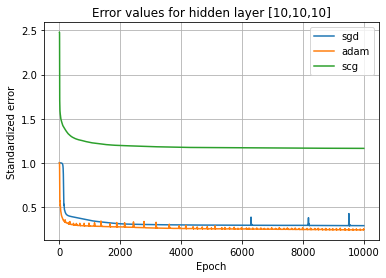

In [26]:
errors = []
n_epochs = 10000
method_rhos = [('sgd', 0.01),
               ('adam', 0.01),
               ('scg', None)]

for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [10, 10, 10], 2)
    nnet.train(Xtrain, Ttrain, n_epochs, method=method, learning_rate=rho, verbose=False)
    Ytrain = nnet.use(Xtrain)
    Ytest = nnet.use(Xtest)
    rmse_train = rmse(Ttrain, Ytrain)
    rmse_test = rmse(Ttest, Ytest)
    print( '\nRMSE for training value = ', rmse_train, '\nRMSE for testing value = ', rmse_test, '\n')
    errors.append(nnet.get_error_trace())
    
plt.figure()
plt.clf()
for error_trace in errors:
    plt.plot(error_trace)
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend([mr[0] for mr in method_rhos]);
plt.grid()
plt.title('Error values for hidden layer [10,10,10]');